<center>
    <H1> KNN CLASSIFIER </H1>
    <br>
======================================================================================================================<br>

Naive Bayes Classification algorithm is a type of supervised machine learning algorithm. It is extremely easy to implement in its most basic form, and yet performs quite complex classification tasks.
We’ll build a simple email classifier using Multinomial Naive Bayes Classifier.


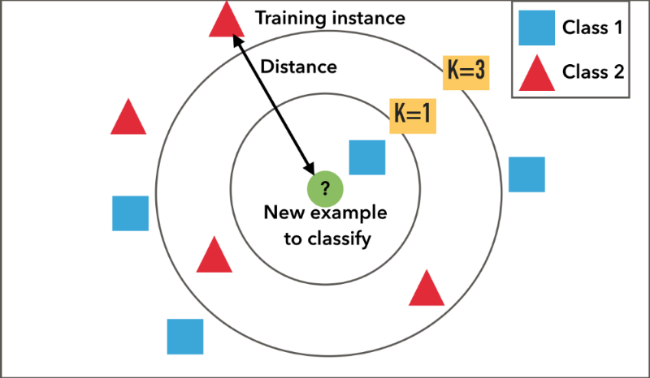

## STEP 1: IMPORTING LIBRARIES

In [66]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer  
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import math 
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

## STEP 2: LOADING DATASET

Load the required dataset

In [67]:
mails_dataset = pd.read_csv('Dataset/emails.csv', encoding = 'latin-1')
#mails_dataset = pd.read_csv('Dataset/spam.csv', encoding = 'latin-1')
mails_dataset.head()           #show first 5 rows

,sno,time,subject,sender,body,folder,label
0,1,"Tue, 17 Sep 2019 09:51:40 -0700","Megha, your profile is getting hits",=?UTF-8?B?TGlua2VkSW4=?= <linkedin@e.linkedin....,Please view this email in a browser: \r\nhttps...,Inbox,Social
1,2,"Sun, 29 Sep 2019 02:50:00 +0000 (UTC)","Building A Logistic Regression in Python, Step...","""Medium Daily Digest"" <noreply@medium.com>",Today's highlights\r\n\r\nBuilding A Logistic ...,Inbox,Updates
2,3,"Mon, 12 Aug 2019 01:43:21 +0000 (GMT)",Help us protect you: Security advice from Google,Google <no-reply@accounts.google.com>,Confirm your recovery phone\r\n\r\nmegha.mcs18...,Inbox,Personal
3,4,"Mon, 30 Sep 2019 08:02:38 +0000 (UTC)","Megha, start a conversation with your new conn...",Kashish Gupta via LinkedIn <invitations@linked...,Kashish Gupta has accepted your invitation. Le...,Inbox,Social
4,5,"Wed, 21 Aug 2019 16:21:31 +0000 (UTC)",Prepare for a coding interview in Python,"""Mari from DataCamp"" <team@datacamp.com>","Hi there,\r\n\r\nWe have 10 new courses coveri...",Inbox,Promotions


## STEP 3: FEATURE SELECTION

Select the relevant features, important for mail classification. We can see that column Unamed are irrelevant for our classifier. Thus, we need to remove them. 

In [68]:
#drop undesirable columns
#drop_list = ['Unnamed: 3', 'Unnamed: 4','Unnamed: 5','Unnamed: 6']
mails_dataset.drop(mails_dataset.columns.difference(['sno','subject','body','label']), axis = 1, inplace = True)

mails_dataset.head()

,sno,subject,body,label
0,1,"Megha, your profile is getting hits",Please view this email in a browser: \r\nhttps...,Social
1,2,"Building A Logistic Regression in Python, Step...",Today's highlights\r\n\r\nBuilding A Logistic ...,Updates
2,3,Help us protect you: Security advice from Google,Confirm your recovery phone\r\n\r\nmegha.mcs18...,Personal
3,4,"Megha, start a conversation with your new conn...",Kashish Gupta has accepted your invitation. Le...,Social
4,5,Prepare for a coding interview in Python,"Hi there,\r\n\r\nWe have 10 new courses coveri...",Promotions


In [69]:
mails_dataset['Message'] = mails_dataset[['subject', 'body']].apply(lambda x: ' '.join(x.astype(str)), axis=1)

In [70]:
#Rename the columns, to make it easy to read and manipulate
mails_dataset.rename(columns = {'sno': 'DocID', 'label': 'Label'}, inplace = True)
mails_dataset.drop(['subject','body'], axis = 1, inplace = True)

mails_dataset.head()

,DocID,Label,Message
0,1,Social,"Megha, your profile is getting hits Please vie..."
1,2,Updates,"Building A Logistic Regression in Python, Step..."
2,3,Personal,Help us protect you: Security advice from Goog...
3,4,Social,"Megha, start a conversation with your new conn..."
4,5,Promotions,Prepare for a coding interview in Python Hi th...


In [71]:
mails_dataset['Label'].value_counts()  #count number of each Label

 Personal      238
 Social        151
 Forums        141
 Updates       119
 Promotions     32
Name: Label, dtype: int64

In [72]:
total_mails = mails_dataset.shape[0]            #total number on instances in our dataset
total_mails

681

## STEP 4: DATA PREPROCESSING

We need to clean our data for further processing. Emails may contain a lot of undesirable characters like punctuation marks, stop words, digits, etc which may not be helpful in detecting the spam email

###  A. Convert to lowercase

In [73]:
#convert the data into lower case
mails_dataset['Message'] =  mails_dataset['Message'].str.lower()
mails_dataset.head()

,DocID,Label,Message
0,1,Social,"megha, your profile is getting hits please vie..."
1,2,Updates,"building a logistic regression in python, step..."
2,3,Personal,help us protect you: security advice from goog...
3,4,Social,"megha, start a conversation with your new conn..."
4,5,Promotions,prepare for a coding interview in python hi th...


### B. Convert categorical values to numbers



In [74]:
'''
    Personal : 0
    Social : 1
    Forums : 2
    Updates : 3
    Promotions : 4
    
'''
#mails_dataset['label'] = mails_dataset['label'].map({'ham': 0, 'spam': 1})
#mails_dataset['label'] = mails_dataset['label'].map({'Personal': 0, 'Social' : 1, 'Forums' : 2,'Updates' : 3, 'Promotions' : 4})
mails_dataset.head()

,DocID,Label,Message
0,1,Social,"megha, your profile is getting hits please vie..."
1,2,Updates,"building a logistic regression in python, step..."
2,3,Personal,help us protect you: security advice from goog...
3,4,Social,"megha, start a conversation with your new conn..."
4,5,Promotions,prepare for a coding interview in python hi th...


In [75]:
mails_dataset['Label']=mails_dataset['Label'].str.strip()

In [76]:
dictionary = {'Personal': 0, 'Social' : 1, 'Forums' : 2,'Updates' : 3, 'Promotions' : 4}
mails_dataset=mails_dataset.replace({"Label": dictionary})
mails_dataset.head()

,DocID,Label,Message
0,1,1,"megha, your profile is getting hits please vie..."
1,2,3,"building a logistic regression in python, step..."
2,3,0,help us protect you: security advice from goog...
3,4,1,"megha, start a conversation with your new conn..."
4,5,4,prepare for a coding interview in python hi th...


### C. Remove digits and punctutations

In [77]:
#remove all digits
mails_dataset['Message'] = mails_dataset['Message'].str.replace('\d+.\d+', '')
mails_dataset.head()

,DocID,Label,Message
0,1,1,"megha, your profile is getting hits please vie..."
1,2,3,"building a logistic regression in python, step..."
2,3,0,help us protect you: security advice from goog...
3,4,1,"megha, start a conversation with your new conn..."
4,5,4,prepare for a coding interview in python hi th...


In [78]:
'''
     ^   :  Not these characters
     \w  :  Word characters
     \s  :  Space characters

    Replace any character that is not a word character or a space character with nothing/blank.
    
'''
mails_dataset['Message'] = mails_dataset['Message'].str.replace('[^\w\s]', '')
mails_dataset.head()

,DocID,Label,Message
0,1,1,megha your profile is getting hits please view...
1,2,3,building a logistic regression in python step ...
2,3,0,help us protect you security advice from googl...
3,4,1,megha start a conversation with your new conne...
4,5,4,prepare for a coding interview in python hi th...


In [79]:
sample_mail = mails_dataset.iloc[0]
sample_mail['Message']

'megha your profile is getting hits please view this email in a browser \r\nhttpselinkedincompubsfformlink_ri_x0gzc2x3dyqpglljhjlyqgn9zfezbymbzf35enzgsrm98sgilihzbazbkwzdwezdzebuncrk6homprvxmtx3dyqpglljhjlyqgu2ukmcdioiucuedsd8nm5wgjocvkgokgzgni1qryl75on6zdv7zcwcdf_ei_evpx2zyzpfwmdastehmmwcjongvnq7xm_nijszrbxhbpzjyjg3d3d\r\n\r\nif you need assistance or have questions please contact linkedin customer service \r\nhttpselinkedincompubcc_ri_x0gzc2x3dyqpglljhjlyqgn9zfezbymbzf35enzgsrm98sgilihzbazbkwzdwezdzebuncrk6homprvxtpkx3dswtdcsy_ei_eolaggf4snmvxff7kuckuwmuru2mcbogxku09vjwvrf62zxhf1xwquo9ggtofxh0anawteojssxgjg3d3d \r\n\r\nthis is an occasional email to help you get the most out of linkedin unsubscribe \r\nhttpselinkedincompubcc_ri_x0gzc2x3dyqpglljhjlyqgn9zfezbymbzf35enzgsrm98sgilihzbazbkwzdwezdzebuncrk6homprvxtpkx3dswsuusy_ei_eolaggf4snmvxff7kuckuwmuru2mcbogxku09vj9mjfzbx7rmjiwphlqcq2lo9bykgkwjfw_qmhspmnpfx8wuujzy1pn_2zuq52as8etm7nsukdkxvmqo91cluos8gymlqczsiohieeg1emqgvotjxusdabmuafbmgo

### D. Convert all the slang words to corresponding formal words

Slang is the popular informal form of a word or group of words.

In [80]:
#create a dictionary of slang words and their corresponding terms

slang_list = {'u': 'you', 'r': 'are', 'd': "the", 'urs' : 'yours', 'wkly' : 'weekly', 'st' : 'such that', 
              'txt': 'text','comp': 'competition', 'prctc' : 'practice', 'dffrnc': 'difference', 'y': 'why', 
              'f9':'fine', 'tkts': 'tickets', 'csh': 'cash', 'phn': 'phone', 'im': 'i am', 'm': 'am', 
              'spcl': 'special', 'fone': 'phone', 'wks' : 'weeks', 'å': 'a', 'n': 'and', 'wat':'what'}


In [81]:
#replace slang with formal word

sample_mail = mails_dataset.iloc[0]
message = sample_mail['Message']
print(message)

new_message = ' '.join(slang_list[i] if i in slang_list else i for i in message.split())
new_message

megha your profile is getting hits please view this email in a browser 
httpselinkedincompubsfformlink_ri_x0gzc2x3dyqpglljhjlyqgn9zfezbymbzf35enzgsrm98sgilihzbazbkwzdwezdzebuncrk6homprvxmtx3dyqpglljhjlyqgu2ukmcdioiucuedsd8nm5wgjocvkgokgzgni1qryl75on6zdv7zcwcdf_ei_evpx2zyzpfwmdastehmmwcjongvnq7xm_nijszrbxhbpzjyjg3d3d

if you need assistance or have questions please contact linkedin customer service 
httpselinkedincompubcc_ri_x0gzc2x3dyqpglljhjlyqgn9zfezbymbzf35enzgsrm98sgilihzbazbkwzdwezdzebuncrk6homprvxtpkx3dswtdcsy_ei_eolaggf4snmvxff7kuckuwmuru2mcbogxku09vjwvrf62zxhf1xwquo9ggtofxh0anawteojssxgjg3d3d 

this is an occasional email to help you get the most out of linkedin unsubscribe 
httpselinkedincompubcc_ri_x0gzc2x3dyqpglljhjlyqgn9zfezbymbzf35enzgsrm98sgilihzbazbkwzdwezdzebuncrk6homprvxtpkx3dswsuusy_ei_eolaggf4snmvxff7kuckuwmuru2mcbogxku09vj9mjfzbx7rmjiwphlqcq2lo9bykgkwjfw_qmhspmnpfx8wuujzy1pn_2zuq52as8etm7nsukdkxvmqo91cluos8gymlqczsiohieeg1emqgvotjxusdabmuafbmgoo1pv5ih8vaciga3ltbng9x

'megha your profile is getting hits please view this email in a browser httpselinkedincompubsfformlink_ri_x0gzc2x3dyqpglljhjlyqgn9zfezbymbzf35enzgsrm98sgilihzbazbkwzdwezdzebuncrk6homprvxmtx3dyqpglljhjlyqgu2ukmcdioiucuedsd8nm5wgjocvkgokgzgni1qryl75on6zdv7zcwcdf_ei_evpx2zyzpfwmdastehmmwcjongvnq7xm_nijszrbxhbpzjyjg3d3d if you need assistance or have questions please contact linkedin customer service httpselinkedincompubcc_ri_x0gzc2x3dyqpglljhjlyqgn9zfezbymbzf35enzgsrm98sgilihzbazbkwzdwezdzebuncrk6homprvxtpkx3dswtdcsy_ei_eolaggf4snmvxff7kuckuwmuru2mcbogxku09vjwvrf62zxhf1xwquo9ggtofxh0anawteojssxgjg3d3d this is an occasional email to help you get the most out of linkedin unsubscribe httpselinkedincompubcc_ri_x0gzc2x3dyqpglljhjlyqgn9zfezbymbzf35enzgsrm98sgilihzbazbkwzdwezdzebuncrk6homprvxtpkx3dswsuusy_ei_eolaggf4snmvxff7kuckuwmuru2mcbogxku09vj9mjfzbx7rmjiwphlqcq2lo9bykgkwjfw_qmhspmnpfx8wuujzy1pn_2zuq52as8etm7nsukdkxvmqo91cluos8gymlqczsiohieeg1emqgvotjxusdabmuafbmgoo1pv5ih8vaciga3ltbng9xojg3d

In [82]:
#applying to all rows

def convert_slangs(row):
    message = row['Message']
    new_message = ' '.join(slang_list[i] if i in slang_list else i for i in message.split())
    return new_message

mails_dataset['Message'] = mails_dataset.apply(convert_slangs, axis=1)
mails_dataset.head()

,DocID,Label,Message
0,1,1,megha your profile is getting hits please view...
1,2,3,building a logistic regression in python step ...
2,3,0,help us protect you security advice from googl...
3,4,1,megha start a conversation with your new conne...
4,5,4,prepare for a coding interview in python hi th...


### E. Tokenization

In [83]:
#pick every message and convert it into tokens

def identify_tokens(row):
    message = row['Message']
    tokens = word_tokenize(message)
    token_words = [w for w in tokens if w.isalpha()]
    return token_words

mails_dataset['Tokens'] = mails_dataset.apply(identify_tokens, axis=1)
mails_dataset.head()

,DocID,Label,Message,Tokens
0,1,1,megha your profile is getting hits please view...,"[megha, your, profile, is, getting, hits, plea..."
1,2,3,building a logistic regression in python step ...,"[building, a, logistic, regression, in, python..."
2,3,0,help us protect you security advice from googl...,"[help, us, protect, you, security, advice, fro..."
3,4,1,megha start a conversation with your new conne...,"[megha, start, a, conversation, with, your, ne..."
4,5,4,prepare for a coding interview in python hi th...,"[prepare, for, a, coding, interview, in, pytho..."


### F. Stemming / Lemmatization

Both processes reduce the inflectional forms of word into a common base or root. But we are using lemmatization because it takes care of the context, while stemming simply performs crude cutoff...

In [84]:
'''
stemming = PorterStemmer()
sample_mail = mails_dataset.iloc[0]
tokens = sample_mail['Tokens']
stemmed_list = [stemming.stem(word) for word in tokens]
stemmed_list
'''

"\nstemming = PorterStemmer()\nsample_mail = mails_dataset.iloc[0]\ntokens = sample_mail['Tokens']\nstemmed_list = [stemming.stem(word) for word in tokens]\nstemmed_list\n"

In [85]:
lemmatizer = WordNetLemmatizer() 

sample_mail = mails_dataset.iloc[0]
tokens = sample_mail['Tokens']
lemmatize_list = [lemmatizer.lemmatize(word) for word in tokens]
lemmatize_list

['megha',
 'your',
 'profile',
 'is',
 'getting',
 'hit',
 'please',
 'view',
 'this',
 'email',
 'in',
 'a',
 'browser',
 'if',
 'you',
 'need',
 'assistance',
 'or',
 'have',
 'question',
 'please',
 'contact',
 'linkedin',
 'customer',
 'service',
 'this',
 'is',
 'an',
 'occasional',
 'email',
 'to',
 'help',
 'you',
 'get',
 'the',
 'most',
 'out',
 'of',
 'linkedin',
 'unsubscribe',
 'this',
 'email',
 'wa',
 'intended',
 'for',
 'megha',
 'learn',
 'why',
 'we',
 'include',
 'this',
 'httphelplinkedincomappanswersglobalidfteng',
 'copyright',
 'linkedin',
 'corporation',
 'all',
 'right',
 'reserved',
 'linkedin',
 'corp',
 'west',
 'maude',
 'avenue',
 'sunnyvale',
 'ca']

In [86]:
def lemmatize_tokens(row):
    tokens = row['Tokens']
    lemmatized_list = [lemmatizer.lemmatize(word) for word in tokens]
    return (lemmatized_list)

mails_dataset['Tokens'] = mails_dataset.apply(lemmatize_tokens, axis=1)
mails_dataset.head()

,DocID,Label,Message,Tokens
0,1,1,megha your profile is getting hits please view...,"[megha, your, profile, is, getting, hit, pleas..."
1,2,3,building a logistic regression in python step ...,"[building, a, logistic, regression, in, python..."
2,3,0,help us protect you security advice from googl...,"[help, u, protect, you, security, advice, from..."
3,4,1,megha start a conversation with your new conne...,"[megha, start, a, conversation, with, your, ne..."
4,5,4,prepare for a coding interview in python hi th...,"[prepare, for, a, coding, interview, in, pytho..."


### G. Remove stopwords

Stopwords are common words that carry less important meaning than keywords. So, we will remove them.

In [87]:
stop_words = set(stopwords.words('english'))
print(stop_words,)

{'y', 'them', 'itself', 'd', 'are', 'doing', 've', "doesn't", 'of', 'than', 'shan', "aren't", 'what', 'isn', "needn't", 'our', 'aren', 'most', "wasn't", 'he', 'few', 'until', 'by', 'to', 'all', 'out', "isn't", 'do', 'they', "you'd", 'through', 'on', 'now', 'o', 'with', 'have', 'how', "you'll", 'which', 'some', "shouldn't", 'ain', 'as', 'ma', "she's", 'their', 'at', 'up', 're', 'will', 'couldn', 'weren', 'before', 'this', 'had', 'am', 'where', "that'll", 'those', "hasn't", 'these', 'for', 'themselves', 'there', 'won', 'from', 'more', "won't", "don't", 'again', 'does', 'yourself', 'being', 'wouldn', "shan't", 'or', 'mightn', 'that', 'me', 'the', 'after', 'down', "didn't", "you're", 'mustn', "wouldn't", 'same', 'own', 'ours', 'were', 'yourselves', 'both', 'once', 'only', 'and', 'i', 'my', 'you', 'then', 'no', 'his', 'she', 'him', 'doesn', 'myself', 'not', 'hasn', 'theirs', 'haven', 't', 'be', 'under', 'who', "couldn't", "hadn't", "haven't", 'her', 'such', 'm', 'just', 'hers', 'it', 'above

In [88]:
def remove_stopwords(row):
    tokens = row['Tokens']
    filtered_list = [w for w in tokens if not w in stop_words]
    return (filtered_list)

mails_dataset['Tokens'] = mails_dataset.apply(remove_stopwords , axis=1)
mails_dataset.head()

,DocID,Label,Message,Tokens
0,1,1,megha your profile is getting hits please view...,"[megha, profile, getting, hit, please, view, e..."
1,2,3,building a logistic regression in python step ...,"[building, logistic, regression, python, step,..."
2,3,0,help us protect you security advice from googl...,"[help, u, protect, security, advice, google, c..."
3,4,1,megha start a conversation with your new conne...,"[megha, start, conversation, new, connection, ..."
4,5,4,prepare for a coding interview in python hi th...,"[prepare, coding, interview, python, hi, new, ..."


### >>>> Now our data is clean and ready for further processing <<<<

## STEP 5: CREATING DOCUMENT TERM MATRIX


### A. Convert each document to a count vector

In [89]:
#list of tokens are combined to create the message

tkn = mails_dataset['Tokens'].iloc[0]
msg = ' '.join(tkn) 
msg

'megha profile getting hit please view email browser need assistance question please contact linkedin customer service occasional email help get linkedin unsubscribe email wa intended megha learn include httphelplinkedincomappanswersglobalidfteng copyright linkedin corporation right reserved linkedin corp west maude avenue sunnyvale ca'

In [90]:
corpus = []                          #list of prepocessed documents, where each term is the text of the document
for row in range(total_mails):
    tkn = mails_dataset['Tokens'].iloc[row]
    msg = ' '.join(tkn)
    corpus.append(msg)

corpus[:5]   #print first 5 instances

['megha profile getting hit please view email browser need assistance question please contact linkedin customer service occasional email help get linkedin unsubscribe email wa intended megha learn include httphelplinkedincomappanswersglobalidfteng copyright linkedin corporation right reserved linkedin corp west maude avenue sunnyvale ca',
 'building logistic regression python step step susan li towards data science today highlight building logistic regression python step step logistic regression machine learning classification algorithm used predict probability ofâ susan li towards data science min read topic modeling data visualization pythonflask recently became interested data visualization topic modeling python one problem withâ ethan jarrell hackernooncom min read building beautiful command line interface python building command line interface using python oyetoke tobi emmanuel codeburst min read introduction environment variable use decoupling configuration application jim medloc

In [91]:
#document term matrix
vec = CountVectorizer()
X = vec.fit_transform(corpus)
df = pd.DataFrame(X.toarray(), columns = vec.get_feature_names())
df.head()

,aa,aakanksha,aanchal,aanchalguptasrccgmailcom,aanshul,aap,aapne,aaron,aarora,aashna,...,ââthe,âââââââââââââââââââââââââââââ,âï,âïâ,ãzler,ðââï,ðâðð,ððð,ðððð,ðððððððððð
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [92]:
vector_dim = len(vec.get_feature_names())   #dimension of each vector
vector_dim

7666

In [93]:
#Create final dtm. column 0 will tell the document number while column 1 will tell the label. 

dtm = pd.concat([mails_dataset,df], axis=1, ignore_index=False, sort=False).reset_index(drop=True)
drop_list = ['Message', 'Tokens']
dtm.drop(drop_list, axis = 1, inplace=True)
dtm.head()

,DocID,Label,aa,aakanksha,aanchal,aanchalguptasrccgmailcom,aanshul,aap,aapne,aaron,...,ââthe,âââââââââââââââââââââââââââââ,âï,âïâ,ãzler,ðââï,ðâðð,ððð,ðððð,ðððððððððð
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### >>>Now every document in the corpus has a vector representation<<<

## STEP 6: CREATING TEST AND TRAIN SETS

We will randomly split our dataset in 80–20 ratio. Where 80% of the total data will be used as training set and rest 20% will be considered as test set. 

In [94]:
X = dtm.drop('Label',axis=1) 
y = dtm['Label']

#random state = 0, will give same split evry time. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [95]:
test_size, train_size = X_test.shape[0], X_train.shape[0]
print("Number of instance in :\n Training set = ", train_size, "\n Test set = ", test_size)

Number of instance in :
 Training set =  544 
 Test set =  137


In [96]:
X_train.head()

,DocID,aa,aakanksha,aanchal,aanchalguptasrccgmailcom,aanshul,aap,aapne,aaron,aarora,...,ââthe,âââââââââââââââââââââââââââââ,âï,âïâ,ãzler,ðââï,ðâðð,ððð,ðððð,ðððððððððð
200,263,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
380,514,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
236,312,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
101,133,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
667,904,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [97]:
#y_train is an array. so in order to concat it with our X variables, we need to convert it into dataframe

labels_train = pd.DataFrame(y_train, columns = ['Label'])
labels_train.head()

,Label
200,1
380,3
236,2
101,0
667,0


In [98]:
'''
    We have X_train, y_train, X_test, y_test.
    Using these lists and dataframes we will randomly create two non-overlapping datasets 
        1. training set
        2. testing set
'''

#creating training set
train_dtm = pd.concat([X_train, labels_train], axis = 1).reset_index(drop=True)
train_dtm.head()

,DocID,aa,aakanksha,aanchal,aanchalguptasrccgmailcom,aanshul,aap,aapne,aaron,aarora,...,âââââââââââââââââââââââââââââ,âï,âïâ,ãzler,ðââï,ðâðð,ððð,ðððð,ðððððððððð,Label
0,263,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,514,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2,312,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,133,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,904,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [99]:
# Our training set is ready, similarly creating test set

labels_test = pd.DataFrame(y_test, columns = ['Label'])
test_dtm = pd.concat([X_test, labels_test], axis = 1).reset_index(drop=True)
test_dtm.head()

,DocID,aa,aakanksha,aanchal,aanchalguptasrccgmailcom,aanshul,aap,aapne,aaron,aarora,...,âââââââââââââââââââââââââââââ,âï,âïâ,ãzler,ðââï,ðâðð,ððð,ðððð,ðððððððððð,Label
0,146,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,805,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,337,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
3,750,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,373,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## STEP 7: TESTING CLASSIFIER

Predicting the output class for the every instance in the test data

### A. Compute distance / similarity

Calculate distance between test data and each example of training data using Euclidean distance.


In [100]:
#train_dtm.iloc[2][1:-1]

In [101]:
'''
    Function to calculate Euclidean distance between two vectors. 
      -  One is test vector(whose class is to be predicted)
      -  Other is given example(whose class is known)

'''

def euclideanDistance(test_case, data, vector_dim):
    distance = 0        
    i =  1                      #starting from position 1, as position 0 contains DocID
    for i in range(vector_dim):          
        distance += pow((test_case[i] - data[i]), 2)          #formula for Euclidean Distance
    return math.sqrt(distance)

In [102]:
d1 = test_dtm.iloc[2]
d2 = train_dtm.iloc[5]
distance = euclideanDistance(d1, d2, vector_dim)
distance

441.1076966002747

### B. Locate K Nearset Neighbors 

Sort the calculated distance in ascending order and get top K rows from the sorted array.

In [103]:
import operator 

def kNearestNeighbors(test_case, k):
    distances = []
    
    for example in range(train_size):
        data = train_dtm.iloc[example]
        dist = euclideanDistance(test_case, data, vector_dim)
        distances.append((train_dtm['DocID'].iloc[example], dist))  #store (DocID,Label,Distance from test_case)
        
    dis = dict(distances)                                           # key : DocID, value : Distance       
    sorted_distances = sorted(dis.items(), key=operator.itemgetter(1))     #itemgetter(1): sort on values
     
    nearest_neighbors = []
    for x in range(k):                     #select top k neighbors
        nearest_neighbors.append(sorted_distances[x][0])
        
    return nearest_neighbors               # return DocID of top k neighbors

In [104]:
data = train_dtm.iloc[3]
kNearestNeighbors(data, 5)

[133, 130, 131, 124, 128]

### C. Predict the class

Now find out the most frequent class of the K Nearest Neighbors and assign it to the test case.

In [105]:
def predictClass(nearest_neighbors):
    class_votes = {}                  #to get most frequent class of nearest neighbors
    
    for neighbor in range(len(nearest_neighbors)):
        response = train_dtm['Label'].iloc[neighbor]    #get the label of this neighbor
                     
        if(response in class_votes):     # if the label already in list, then increment its vote
            class_votes[response] += 1
        else:
            class_votes[response] = 1    # else add first vote against this label
                           
    sorted_votes = sorted(class_votes.items(), key=operator.itemgetter(1), reverse=True)
    pclass = sorted_votes[0][0]
    
    return pclass
            

In [107]:
data = train_dtm.iloc[3]
predictClass(kNearestNeighbors(data, 5))

0

In [ ]:
'''
    Determine the distance of each test case against all classes. Select top k neighbors with 
    minimun distance from test cases and assign the label which has maximum number of nereast neighbors.

'''       
k = 3
predictions = []                       #to store prediction of each test example\

for row in range(test_size): 
    test_case = train_dtm.iloc[row]
    nearest_neighbors = kNearestNeighbors(test_case, k)
    #predict the class label for each example and append to the predictions list
    predictions.append(predictClass(nearest_neighbors))

#predictions

<b> Testing is over ! </b>
<br>We have predicted labels for each sample in the test set.

## STEP 8: ACCURACY OF THE CLASSIFIER

Accuracy is the fraction of correct predictions our model out of total predictions. 
Formally, accuracy has the following definition:
<br><br>
<center><b> Accuracy = (Number of correct predictions) / (Number of total predictions) 


In [ ]:
#calculate accuracy
predict_labels = np.array(predictions)
actual_labels = np.array(test_dtm['Label'])

test_accuracy = np.sum(predict_labels == actual_labels)/float(test_size) 

print ("******* Test Set Examples ******* : ", test_size)
print ("******* Test Set Accuracy ******* : ", (test_accuracy*100) ,"%") 

In [ ]:
conf_matrix = confusion_matrix(actual_labels, predict_labels)
print(conf_matrix)


In [ ]:
#true_negative
TN = [0]*total_classes
#false_negative
FN = [0]*total_classes
#false_positive
FP = [0]*total_classes
#true_positive
TP = [0]*total_classes

for class_no in range(total_classes):
    for i in range(total_classes):
        for j in range(total_classes):
            if(i==j and i==class_no):
                TP[class_no] = conf_matrix[i][j]
            if(i!=class_no and j!=class_no):
                TN[class_no] += conf_matrix[i][j]
            if(i==class_no and j!=class_no):
                FN[class_no] += conf_matrix[i][j]
            if(j==class_no and i!=class_no):
                FP[class_no] += conf_matrix[i][j]

In [ ]:
correct=0
total=0
for class_no in range(total_classes):
    # Recall is the ratio of the total number of correctly classified positive examples divided by the total number of positive examples. 
    # High Recall indicates the class is correctly recognized (small number of FN)
    recall = (TP[class_no])/(TP[class_no] + FN[class_no])

    # Precision is the the total number of correctly classified positive examples divided by the total number of predicted positive examples. 
    # High Precision indicates an example labeled as positive is indeed positive (small number of FP)
    precision = (TP[class_no])/(TP[class_no] + FP[class_no])

    fmeasure = (2*recall*precision)/(recall+precision)
    correct+=TP[class_no]+TN[class_no]
    total+=TN[class_no] + FN[class_no] + FP[class_no] + TP[class_no]
    print("------ CLASSIFICATION PERFORMANCE OF THE NAIVE BAYES MODEL ------ "\
      "\n class : ", class_no, \
      "\n Recall : ", (recall*100) ,"%" \
      "\n Precision : ", (precision*100) ,"%" \
      "\n F-measure : ", (fmeasure*100) ,"%" )


accuracy = correct/total
print("\n Accuracy : ", (accuracy*100) ,"%" )
#accuracy_score(y_test, y_predict)


